### Environment setup

In [2]:
# remove the warnings
import logging
logging.getLogger().setLevel(logging.ERROR)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
import shutil
import matplotlib.pyplot as plt
import numpy as np
from dataLoader import get_dataset
from model import get_model

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


### Loading data
- download the data **monet_tfrec** and **photo_tfrec** in the dataset folder.
- [config kaggle API](https://github.com/Kaggle/kaggle-api)

(-0.5, 255.5, 255.5, -0.5)

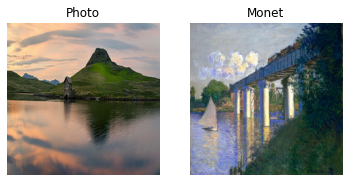

In [3]:
BATCH_SIZE = 32
# monet_ds, photo_ds = get_dataset(BATCH_SIZE)
monet_ds, photo_ds = get_dataset(BATCH_SIZE, repeat=True)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.axis('off')

### Training

In [6]:
from model import CustomCallback

ganModel = get_model()

monet_num = 300
photo_num = 7038

ganModel.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=12,
    # steps_per_epoch=(max(monet_num, photo_num)//16)
    steps_per_epoch=1000,
    callbacks=[CustomCallback()]
)

print('save models...')
ganModel.save()

Epoch 1/12
1000/1000 [==============================] - 856s 843ms/step - monet_gen_loss: 1.2858 - photo_gen_loss: 1.2976 - monet_disc_loss: 0.6511 - photo_disc_loss: 0.6440
Epoch 2/12
1000/1000 [==============================] - 844s 844ms/step - monet_gen_loss: 1.0794 - photo_gen_loss: 1.1333 - monet_disc_loss: 0.6753 - photo_disc_loss: 0.6589
Epoch 3/12
1000/1000 [==============================] - 844s 844ms/step - monet_gen_loss: 0.9766 - photo_gen_loss: 1.0357 - monet_disc_loss: 0.6800 - photo_disc_loss: 0.6593
Epoch 4/12
1000/1000 [==============================] - 844s 844ms/step - monet_gen_loss: 0.9082 - photo_gen_loss: 1.0304 - monet_disc_loss: 0.6858 - photo_disc_loss: 0.6431
Epoch 5/12
1000/1000 [==============================] - 844s 844ms/step - monet_gen_loss: 0.8633 - photo_gen_loss: 0.9448 - monet_disc_loss: 0.6864 - photo_disc_loss: 0.6601
Epoch 6/12
1000/1000 [==============================] - 845s 845ms/step - monet_gen_loss: 0.8288 - photo_gen_loss: 0.9184 - monet_

### Show some reuslts

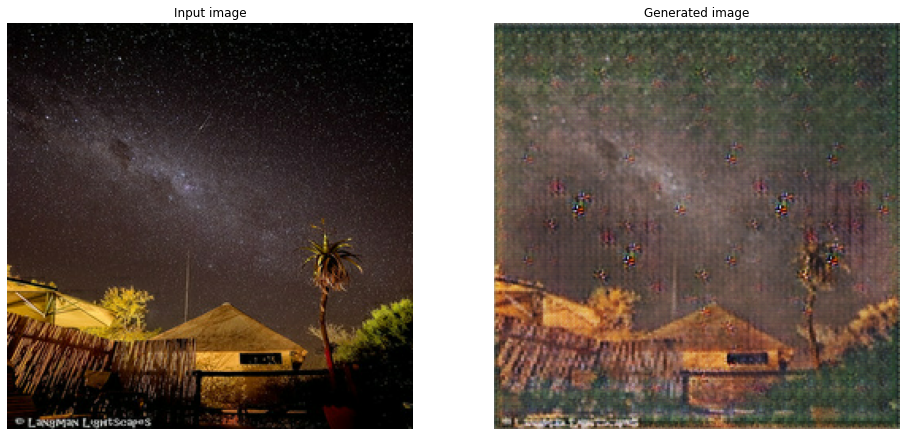

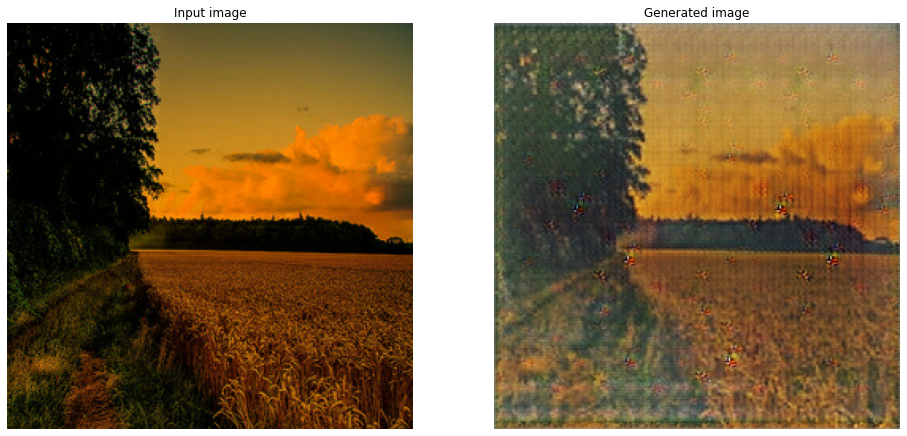

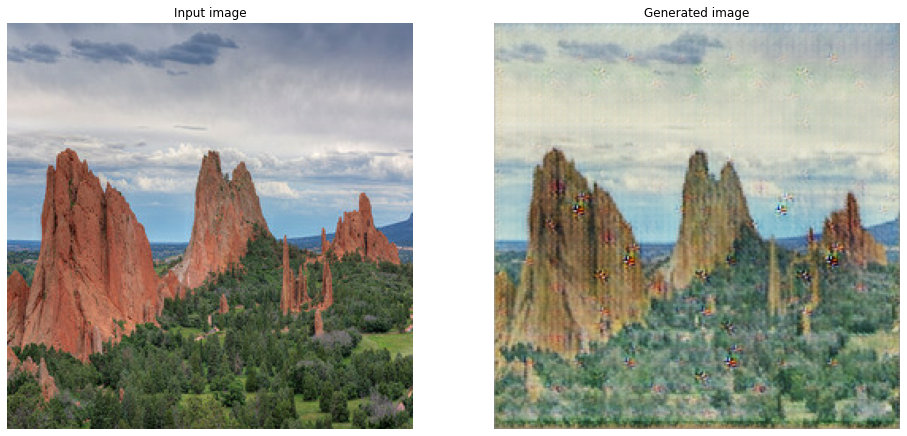

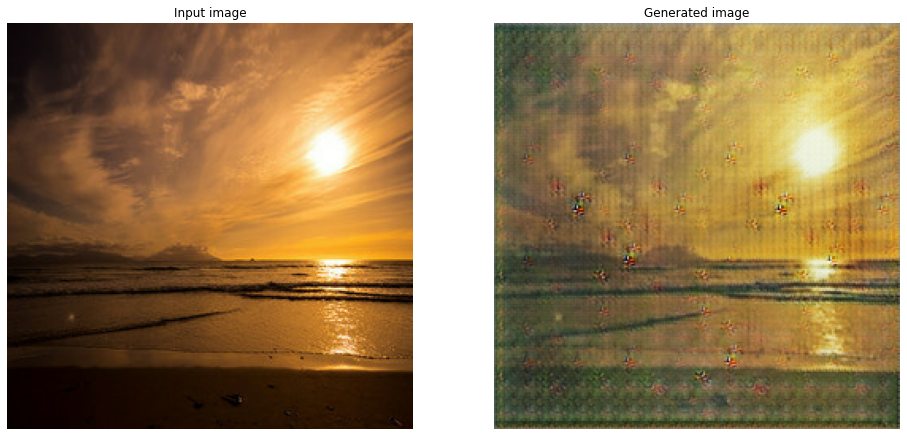

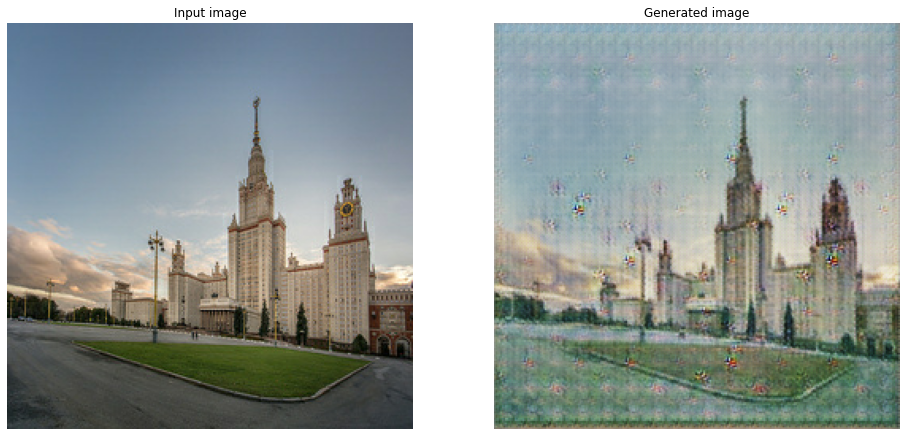

In [5]:
from model.utils import load_models
from dataLoader import get_dataset
monet_generator = load_models(model='m_gen')

_, photo_ds = get_dataset()

ds_iter = iter(photo_ds)
for n_sample in range(5):
    example_sample = next(ds_iter)
    generated_sample = monet_generator(example_sample)

    f = plt.figure(figsize=(16, 16))

    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.axis('off')

    plt.subplot(122)
    plt.title('Generated image')
    plt.imshow(generated_sample[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()


### Save as zip

In [6]:
import PIL
import shutil
if os.path.exists('./ret_imgs') == True:
    shutil.rmtree('./ret_imgs')
os.mkdir('./ret_imgs')

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./ret_imgs/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("./images", 'zip', "./ret_imgs")

'/home/chao/EE5003/I-am-a-painter/images.zip'

### Saliency map

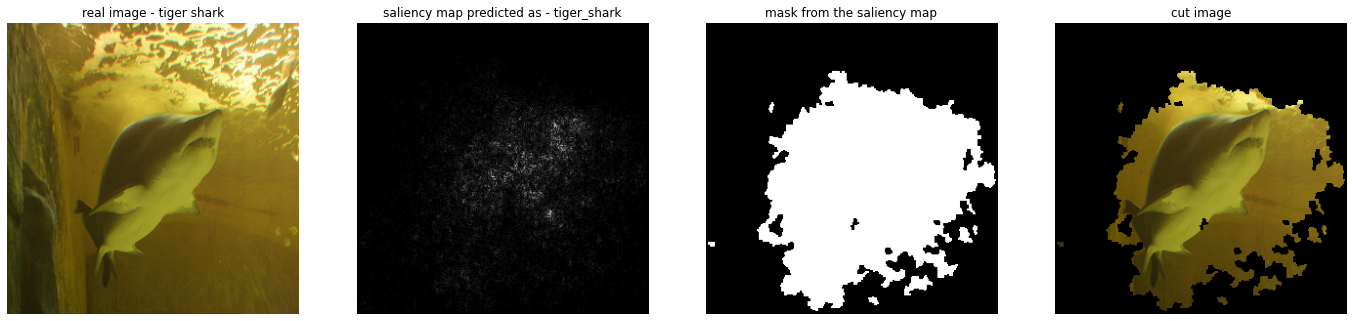

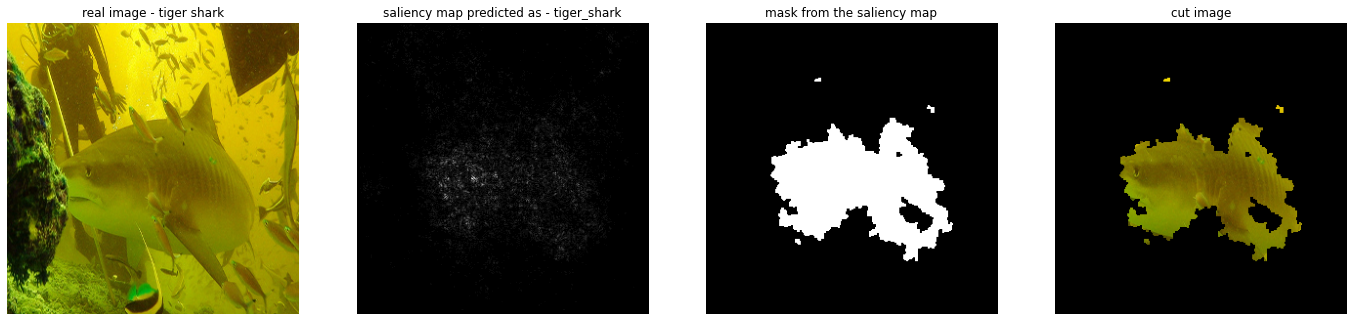

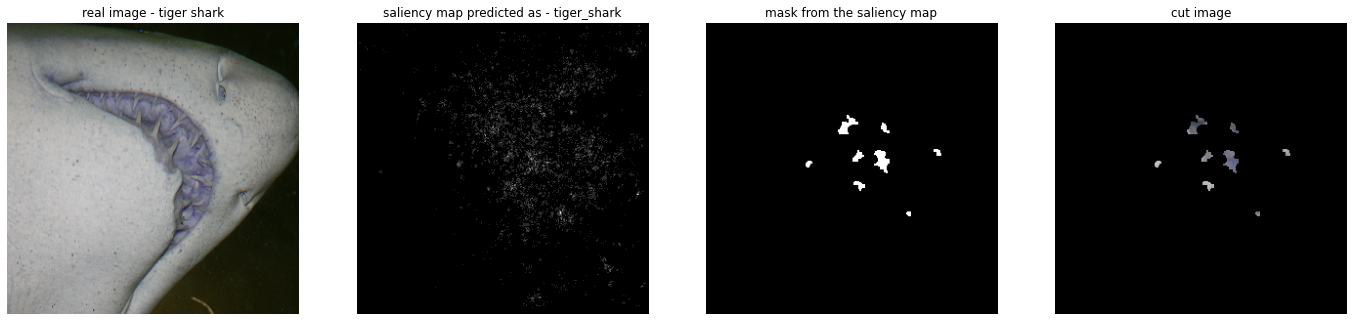

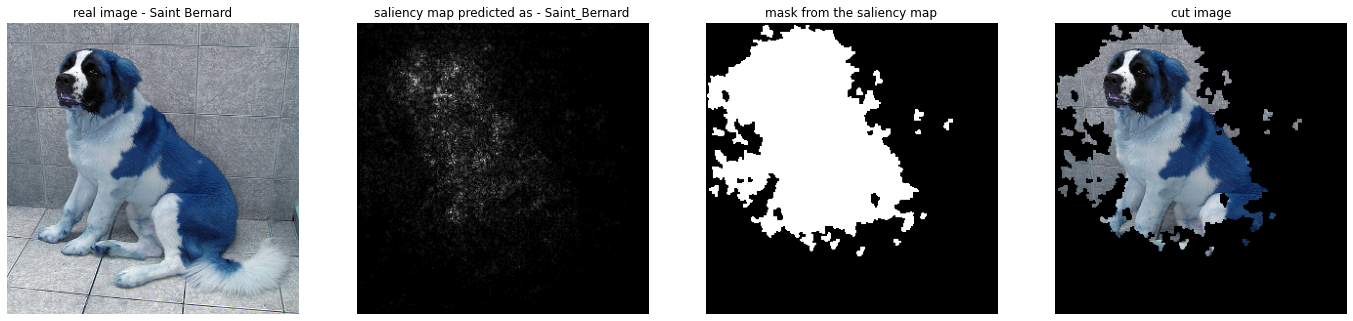

In [10]:
import matplotlib.pyplot as plt
from saliency import get_saliency_map, saliency_graph_cut
from dataLoader import get_saliency_data, imagenet_idx_to_label
import numpy as np

imgs, labels = get_saliency_data(img_shape=(299, 299))
saliency_map, pred_rets = get_saliency_map(imgs, labels)
cut_imgs, masks = saliency_graph_cut(imgs, saliency_map, 10, 0)
# print(saliency_map[0])
# print(pred_rets)
idx_map = imagenet_idx_to_label()

plt_start = 4
img_num = 4

for idx in range(plt_start, plt_start + img_num):
    img = imgs[idx]
    saliency_img = saliency_map[idx]
    mask = masks[idx]
    cut_img = cut_imgs[idx]

    label = idx_map[labels[idx]]
    pred_label = pred_rets[idx][0][1]

    f = plt.figure(figsize=(24, 24))

    plt.subplot(141)
    plt.title(f"real image - {label}")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(142)
    plt.title(f"saliency map predicted as - {pred_label}")
    plt.imshow(saliency_img, cmap='gray')
    plt.axis('off')

    plt.subplot(143)
    plt.title(f"mask from the saliency map")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(144)
    plt.title(f"cut image")
    plt.imshow(cut_img)
    plt.axis('off')

    plt.show()
